In [2]:
import os
import gc

os.chdir('../../')

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import lightgbm as lgb
from scipy.signal import periodogram, detrend

from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
import shap 

from typing import Optional,Dict,Tuple
from pathlib import Path

from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingStd
from mlforecast.target_transforms import Differences, LocalStandardScaler

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mae, coverage, mase

from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingStd
from mlforecast.target_transforms import Differences, AutoDifferences, LocalBoxCox, GlobalSklearnTransformer
from mlforecast.utils import PredictionIntervals
from utilsforecast.plotting import plot_series
import matplotlib.dates as mdates

import os

from sklearn.preprocessing import FunctionTransformer
sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

# plots setup
# https://medium.com/@tttgm/styling-charts-in-seaborn-92136331a541
plt.rcParams.update(**{'figure.dpi': 150})
# color palette can be passed as a list of hex codes
custom_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# set overall plot style, font size scaling factor, and color palette
sns.set(style="whitegrid", font_scale=1, palette=custom_colors)
warnings.filterwarnings("ignore", "use_inf_as_na") # issue with seaborn

/Users/marcus.silva/Code/modern-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading and preprocessing the data

In [10]:
## Read the week_3/data/raw/inflation.csv
df_original= pd.read_csv('week_3/data/raw/inflation.csv')
df = df_original.copy()

In [12]:
# Preprocessing to Nixtla format
df['ds'] = pd.to_datetime(df['Date'])
df = df[df.ds >= '2004-01-01']
df['unique_id'] = 1
df['y'] = df.IPCA
df = df[['unique_id', 'ds', 'y']]
df.head()

/var/folders/02/kk2lyyc1509_l0ltgwm_19y40000gq/T/ipykernel_98452/847401065.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unique_id'] = 1
/var/folders/02/kk2lyyc1509_l0ltgwm_19y40000gq/T/ipykernel_98452/847401065.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df.IPCA


,unique_id,ds,y
24,1,2004-01-01,0.76
25,1,2004-02-01,0.61
26,1,2004-03-01,0.47
27,1,2004-04-01,0.37
28,1,2004-05-01,0.51


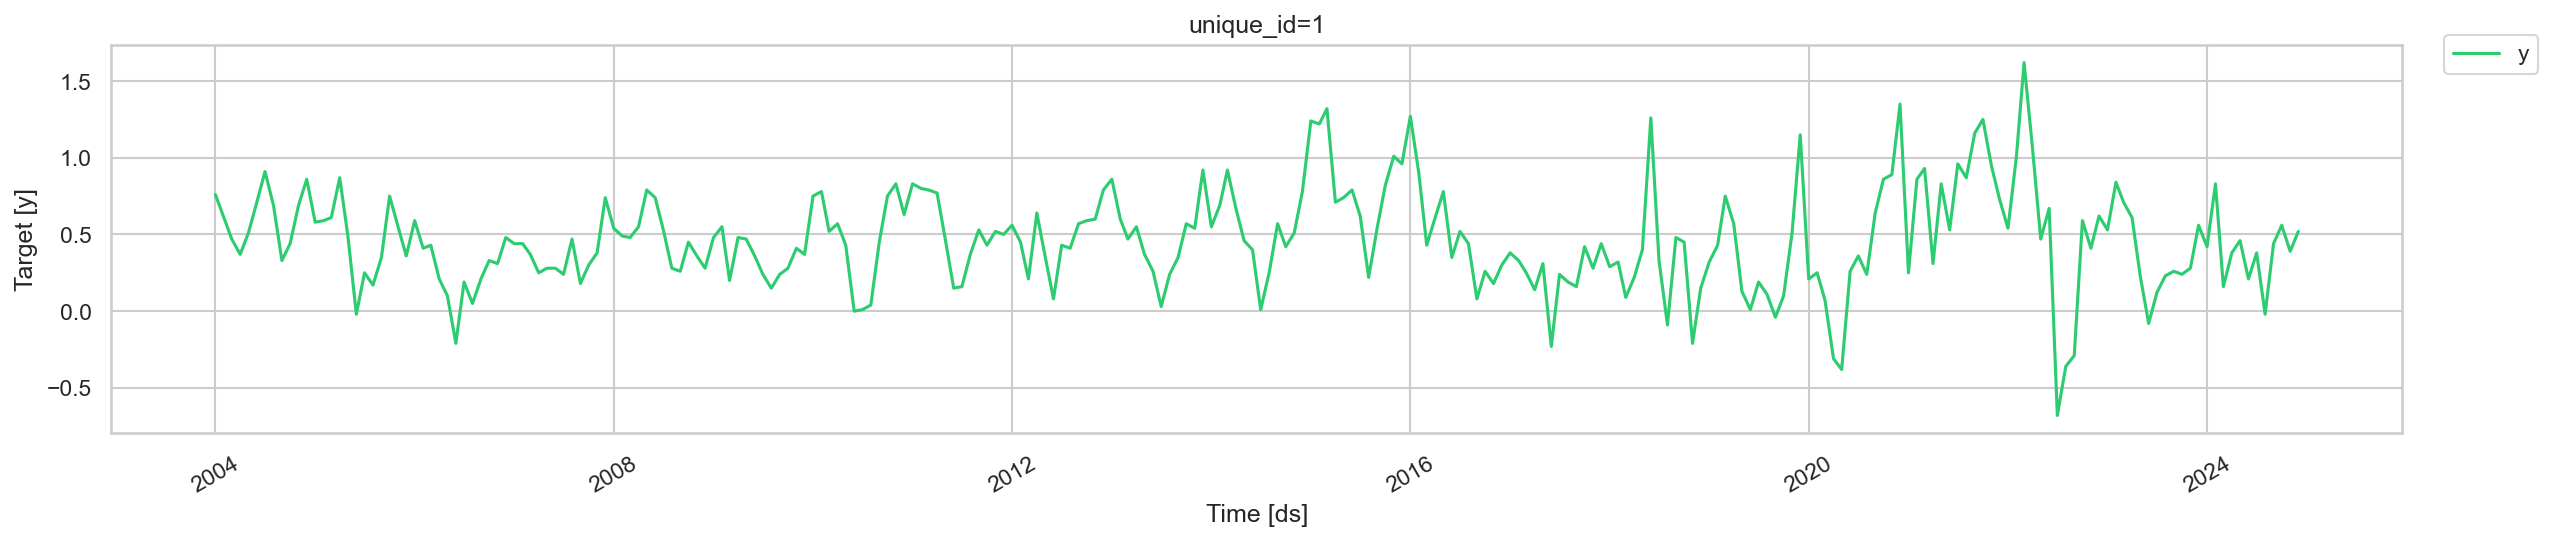

In [13]:
# Plotting the series
fig = plot_series(df)
fig

## Train/Test splint

In [14]:
# ## Train-test split
# We will use the last 12 months as the test set.

df_train = df[df.ds < '2024-01-01']
df_test = df[df.ds >= '2024-01-01']

In [16]:
models  = [
    LinearRegression(),
    CatBoostRegressor(n_estimators=200, random_state=42, verbose=False),
    lgb.LGBMRegressor(n_estimators=200, random_state=42, verbosity=-1)
]
fcst = MLForecast(
    models=models,
    freq='MS',  # our serie has a monthly frequency
    lags=[12, 6, 3, 1],
    
    lag_transforms={
        1: [
            ExpandingMean(),
            RollingMean(window_size=3),
            RollingMean(window_size=6),
            RollingMean(window_size=12),
            RollingStd(window_size=3),
            RollingStd(window_size=6),
            RollingStd(window_size=12),
        ],
        3: [
            ExpandingMean(),
        ],
    },
    date_features=['month', 'quarter'], 
)

In [17]:
# Fit the forecast model
df_train_prep = fcst.preprocess(df_train)
df_train_prep.head()

,unique_id,ds,y,lag12,lag6,lag3,lag1,expanding_mean_lag1,rolling_mean_lag1_window_size3,rolling_mean_lag1_window_size6,rolling_mean_lag1_window_size12,rolling_std_lag1_window_size3,rolling_std_lag1_window_size6,rolling_std_lag1_window_size12,expanding_mean_lag3,month,quarter
36,1,2005-01-01,0.58,0.76,0.91,0.44,0.86,0.612500,0.663333,0.653333,0.612500,0.211266,0.228619,0.188830,0.580000,1,1
37,1,2005-02-01,0.59,0.61,0.69,0.69,0.58,0.610000,0.710000,0.598333,0.597500,0.141067,0.191146,0.183111,0.590000,2,1
38,1,2005-03-01,0.61,0.47,0.33,0.86,0.59,0.608571,0.676667,0.581667,0.595833,0.158850,0.185840,0.183078,0.612500,3,1
39,1,2005-04-01,0.87,0.37,0.44,0.58,0.61,0.608667,0.593333,0.628333,0.607500,0.015275,0.139344,0.178739,0.610000,4,2
40,1,2005-05-01,0.49,0.51,0.69,0.59,0.87,0.625000,0.690000,0.700000,0.649167,0.156205,0.133566,0.176607,0.608571,5,2


## Train a single model and use the recursive strategy

In [18]:
fcst.fit(
    df_train,
    # https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/prediction_intervals.html
    prediction_intervals=PredictionIntervals(n_windows=3, h=12, method="conformal_distribution")
)

MLForecast(models=[LinearRegression, CatBoostRegressor, LGBMRegressor], freq=MS, lag_features=['lag12', 'lag6', 'lag3', 'lag1', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6', 'rolling_mean_lag1_window_size12', 'rolling_std_lag1_window_size3', 'rolling_std_lag1_window_size6', 'rolling_std_lag1_window_size12', 'expanding_mean_lag3'], date_features=['month', 'quarter'], num_threads=1)

In [28]:
df_train_prep, _ = fcst.preprocess(df_train, return_X_y=True)
df_train_prep.head()

,lag12,lag6,lag3,lag1,expanding_mean_lag1,rolling_mean_lag1_window_size3,rolling_mean_lag1_window_size6,rolling_mean_lag1_window_size12,rolling_std_lag1_window_size3,rolling_std_lag1_window_size6,rolling_std_lag1_window_size12,expanding_mean_lag3,month,quarter
36,0.76,0.91,0.44,0.86,0.612500,0.663333,0.653333,0.612500,0.211266,0.228619,0.188830,0.580000,1,1
37,0.61,0.69,0.69,0.58,0.610000,0.710000,0.598333,0.597500,0.141067,0.191146,0.183111,0.590000,2,1
38,0.47,0.33,0.86,0.59,0.608571,0.676667,0.581667,0.595833,0.158850,0.185840,0.183078,0.612500,3,1
39,0.37,0.44,0.58,0.61,0.608667,0.593333,0.628333,0.607500,0.015275,0.139344,0.178739,0.610000,4,2
40,0.51,0.69,0.59,0.87,0.625000,0.690000,0.700000,0.649167,0.156205,0.133566,0.176607,0.608571,5,2


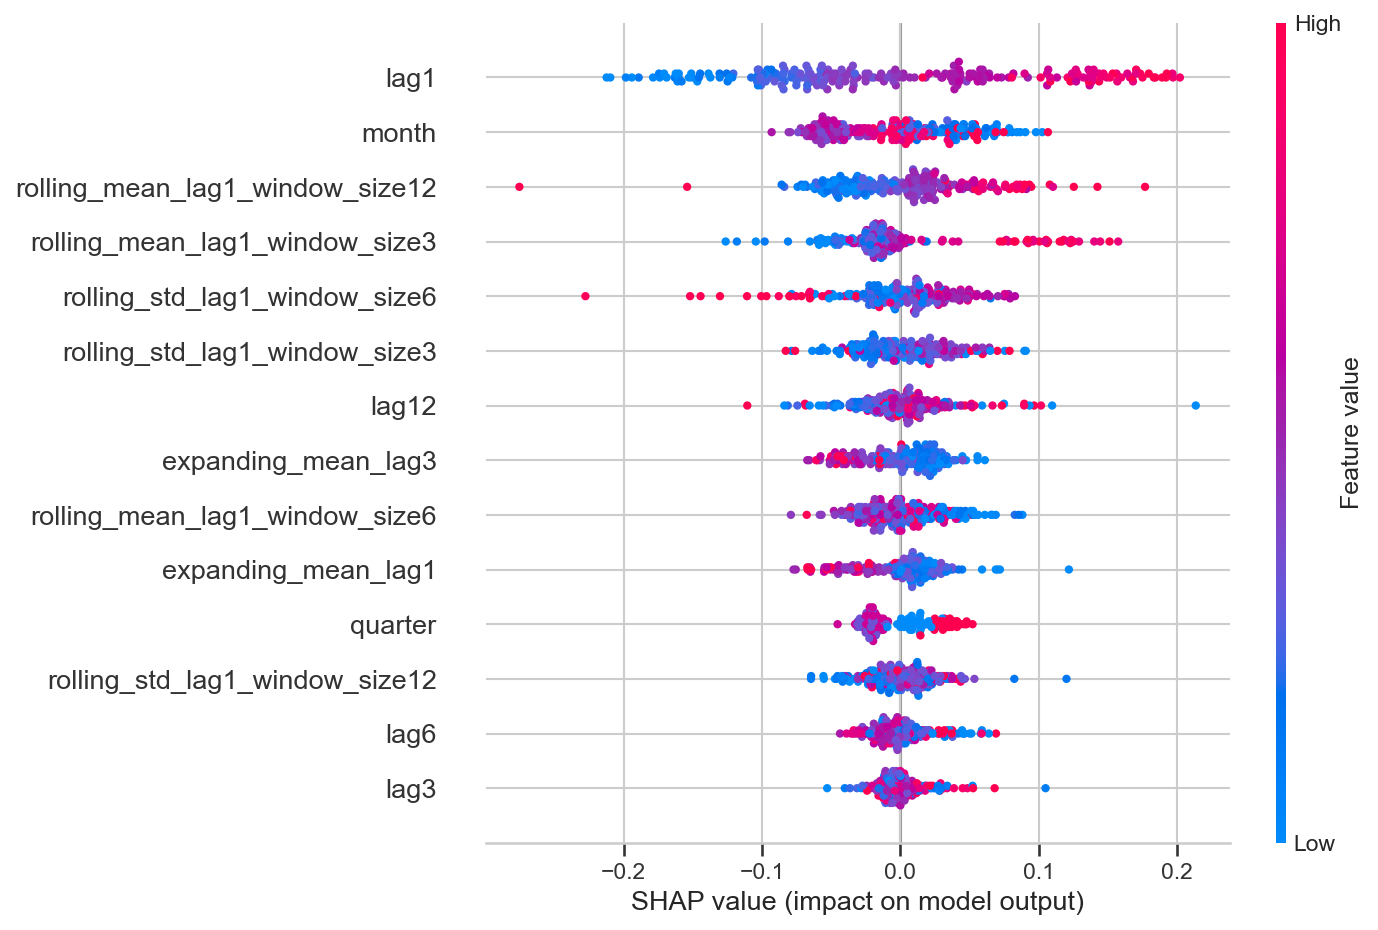

In [20]:
# pre-proc the df_train
df_train_prep, _ = fcst.preprocess(df_train, return_X_y=True)

# Get the catboost model
model = fcst.models_['CatBoostRegressor']

# Getting the SHAP values from the LGBM model
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_train_prep)
shap.plots.beeswarm(shap_values, max_display=25)

In [27]:
predictions = fcst.predict(24,level=levels, X_df=df_test)

ValueError: horizon must be at most max_horizon (12)

In [22]:
predictions.head()

,unique_id,ds,LinearRegression,CatBoostRegressor,LGBMRegressor,LinearRegression-lo-90,LinearRegression-lo-50,LinearRegression-hi-50,LinearRegression-hi-90,CatBoostRegressor-lo-90,CatBoostRegressor-lo-50,CatBoostRegressor-hi-50,CatBoostRegressor-hi-90,LGBMRegressor-lo-90,LGBMRegressor-lo-50,LGBMRegressor-hi-50,LGBMRegressor-hi-90
0,1,2024-01-01,0.522848,0.598839,0.495511,-0.161758,0.113420,0.932276,1.207453,0.079164,0.400113,0.797566,1.118515,0.135923,0.291268,0.699754,0.855098
1,1,2024-02-01,0.495502,0.578915,0.298502,0.085495,0.331317,0.659687,0.905510,0.297956,0.371792,0.786037,0.859873,0.064441,0.139366,0.457637,0.532563
2,1,2024-03-01,0.493838,0.521079,0.194768,-0.478614,0.209850,0.777826,1.466290,-0.164199,0.375750,0.666408,1.206358,-0.496432,0.138555,0.250982,0.885969
3,1,2024-04-01,0.421152,0.383915,0.180165,-0.043722,0.249941,0.592363,0.886025,-0.095716,0.063070,0.704761,0.863546,-0.280928,-0.157437,0.517766,0.641258
4,1,2024-05-01,0.367462,0.243193,0.135330,-0.022495,0.051140,0.683784,0.757419,0.167870,0.178542,0.307843,0.318515,-0.185128,-0.046198,0.316858,0.455788


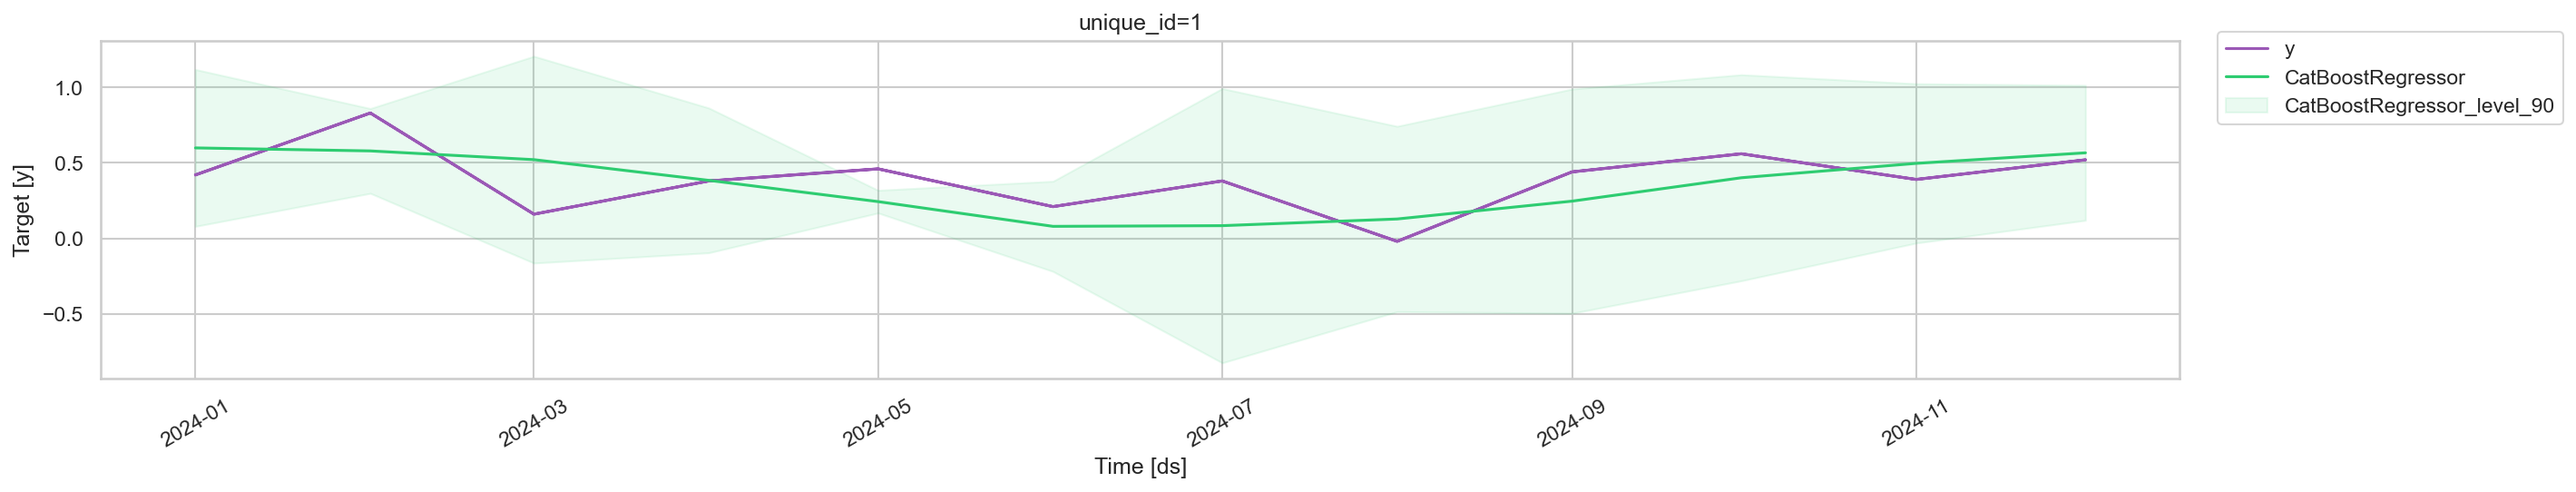

In [121]:
# Merge the test dateset with all predictions
test_df_final = df_test.merge(predictions, how='left', on=['unique_id', 'ds'])

# Plot the model forecasting
fig = plot_series(
    test_df_final, 
    test_df_final, 
    plot_random=False, 
    level=[90],
    max_insample_length=2000,
    models=['CatBoostRegressor'],
)
fig

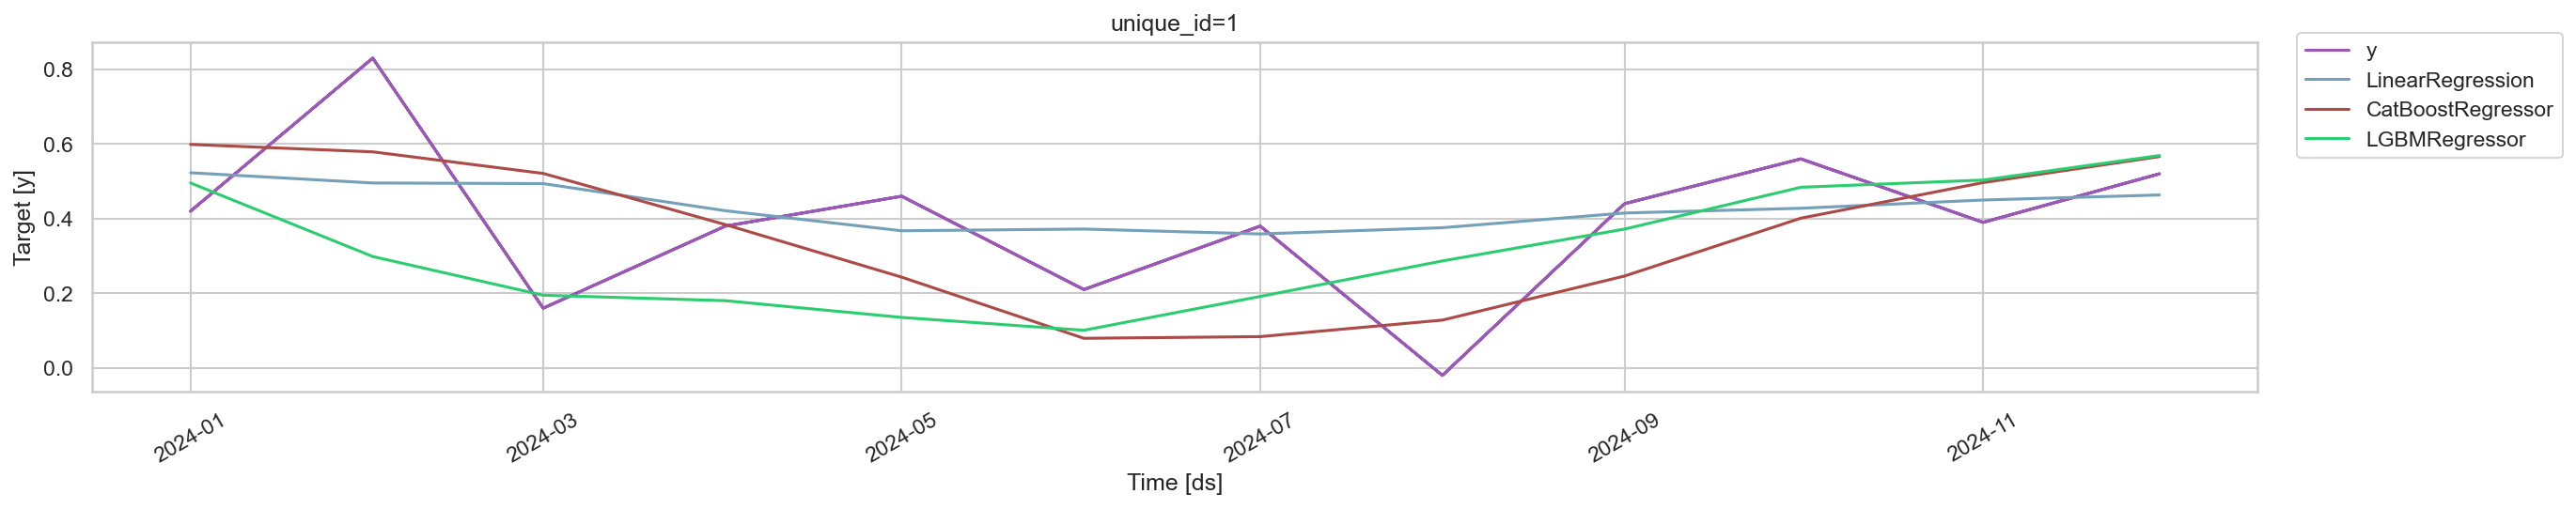

In [122]:
# Plot all models forecasting
fig = plot_series(
    test_df_final, 
    test_df_final, 
    plot_random=False, 
    max_insample_length=2000,
)
fig

In [124]:
metrics = [
    mape,
    mae,
    coverage
]

results = evaluate(test_df_final, metrics, level=[90])
results


,unique_id,metric,LinearRegression,CatBoostRegressor,LGBMRegressor
0,1,mape,2.017451,1.113334,1.607641
1,1,mae,0.146441,0.174329,0.173077
2,1,coverage_level90,0.923077,0.846154,0.769231


## Train 12 models, one for each horizon (One model per step)

In [23]:
# How to use recursive forecasting with MLForecast or One Model Per Horizon
# https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/one_model_per_horizon.html

fcst.fit(
    df_train,
    max_horizon=12, # This feature will be used to train 12 models one for each horizon
    prediction_intervals=PredictionIntervals(n_windows=3, h=12, method="conformal_distribution")
)

MLForecast(models=[LinearRegression, CatBoostRegressor, LGBMRegressor], freq=MS, lag_features=['lag12', 'lag6', 'lag3', 'lag1', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6', 'rolling_mean_lag1_window_size12', 'rolling_std_lag1_window_size3', 'rolling_std_lag1_window_size6', 'rolling_std_lag1_window_size12', 'expanding_mean_lag3'], date_features=['month', 'quarter'], num_threads=1)

In [24]:
levels = [50, 90]
predictions = fcst.predict(12,level=levels, X_df=df_test)

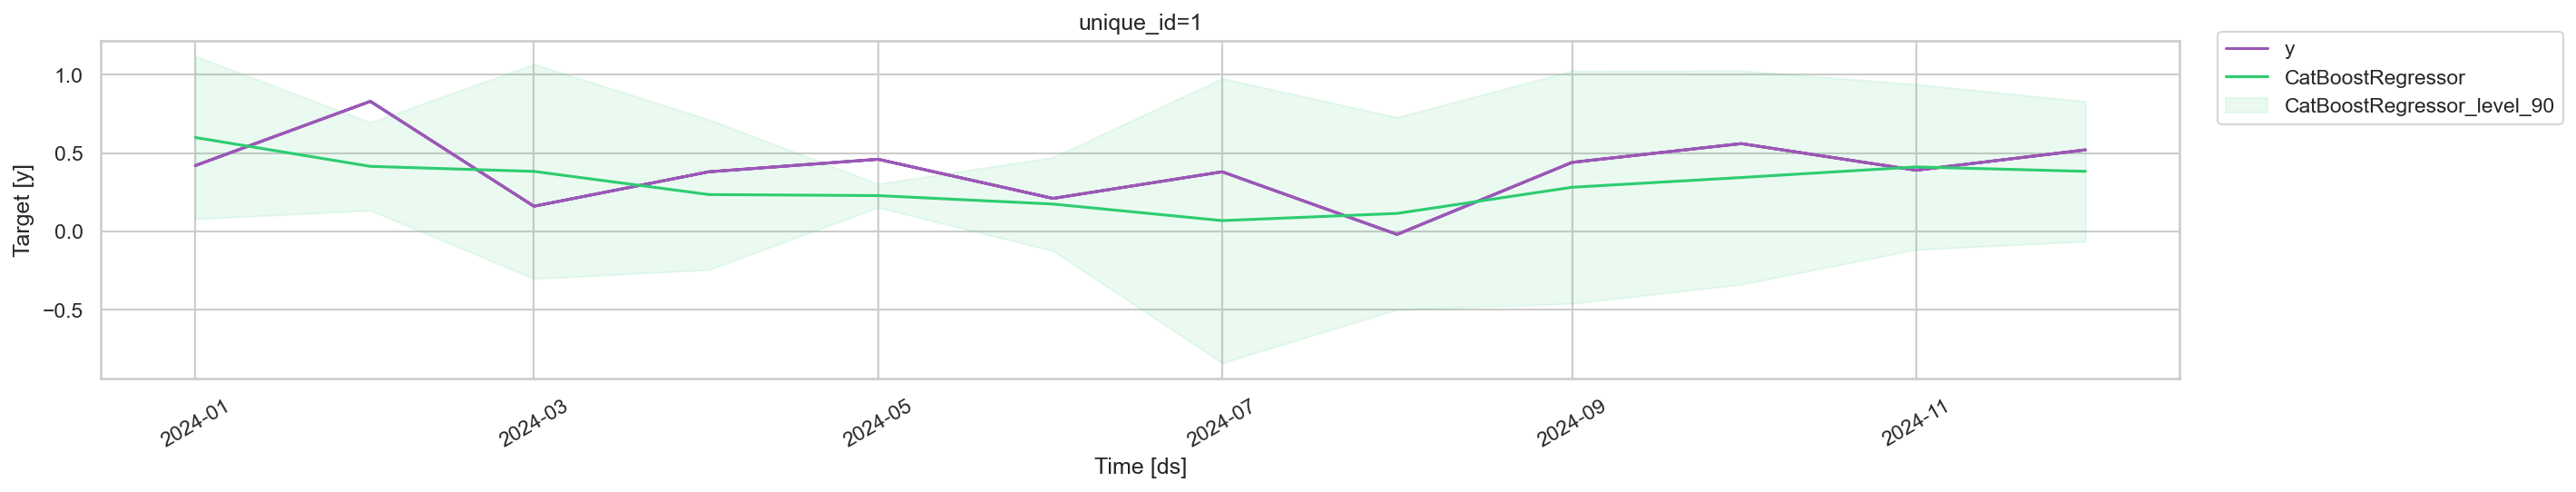

In [25]:
# Merge the test dateset with all predictions
test_df_final = df_test.merge(predictions, how='left', on=['unique_id', 'ds'])

# Plot the model forecasting
fig = plot_series(
    test_df_final, 
    test_df_final, 
    plot_random=False, 
    level=[90],
    max_insample_length=2000,
    models=['CatBoostRegressor'],
)
fig

In [26]:
metrics = [
    mape,
    mae,
    coverage
]
results = evaluate(test_df_final, metrics, level=[90])
results


,unique_id,metric,LinearRegression,CatBoostRegressor,LGBMRegressor
0,1,mape,1.743210,0.997434,1.143230
1,1,mae,0.165635,0.184180,0.240544
2,1,coverage_level90,0.846154,0.769231,0.769231
